In [1]:
import os
import time
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import pytesseract
from pytesseract import Output
from prettytable import PrettyTable

In [2]:
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

./20201007_110604.jpg
./computer-vision-receipt-ocr.ipynb
./IMG_6150.JPG
./IMG_6150_OutReceipt.png
./pytesseract_ocr_receipt.ipynb
./.ipynb_checkpoints\computer-vision-receipt-ocr-checkpoint.ipynb
./.ipynb_checkpoints\pytesseract_ocr_receipt-checkpoint.ipynb


# Load Input

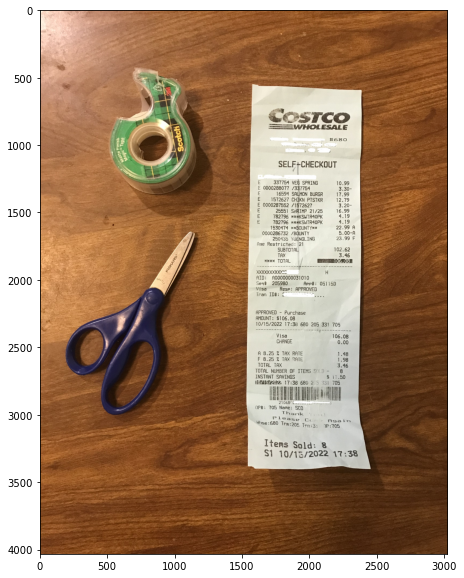

In [43]:
# read in image
file_name = './IMG_6150.jpg'

img = cv2.imread(file_name)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

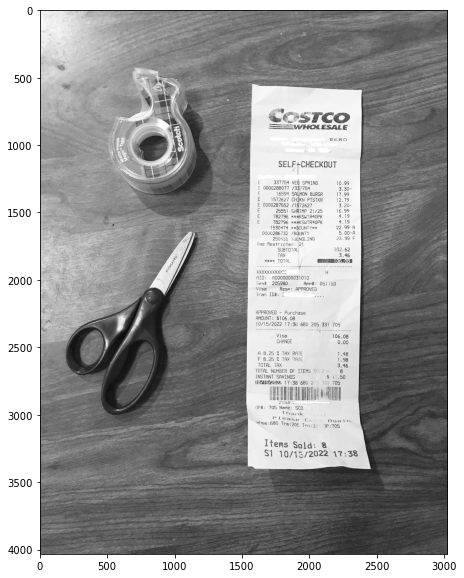

In [44]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize = (10,10))
plt.imshow(gray, cmap='Greys_r')
plt.show()

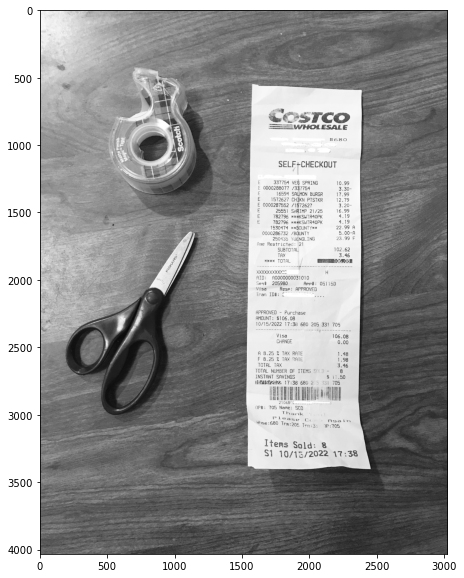

In [45]:
# blur out the receipt
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

plt.figure(figsize = (10,10))
plt.imshow(blurred, cmap='Greys_r')
plt.show()

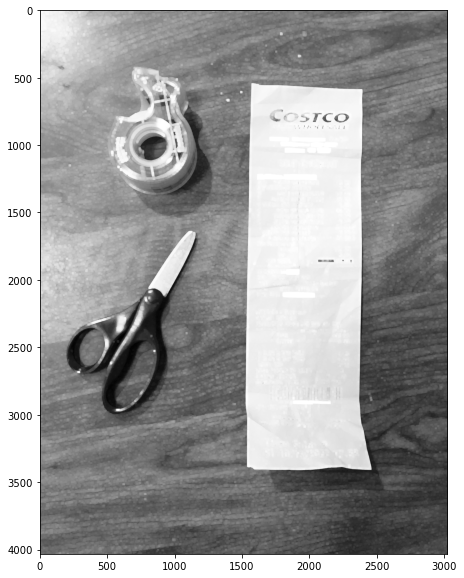

In [46]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
dilated = cv2.dilate(blurred, rectKernel)

plt.figure(figsize = (10,10))
plt.imshow(dilated, cmap='Greys_r')
plt.show()

In [47]:
# Parameters used for edge detection
# we need adjust canny values if we have different images
blur = 21
canny_low = 50
canny_high = 520
min_area = 0.0005
max_area = 0.95
dilate_iter = 10
erode_iter = 10
mask_color = (0.0,0.0,0.0)

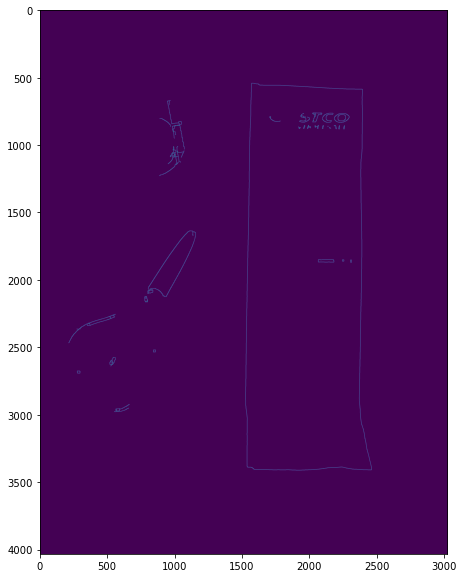

In [48]:
edges = cv2.Canny(dilated, canny_low, canny_high)

plt.figure(figsize = (10,10))
plt.imshow(edges)
plt.show()

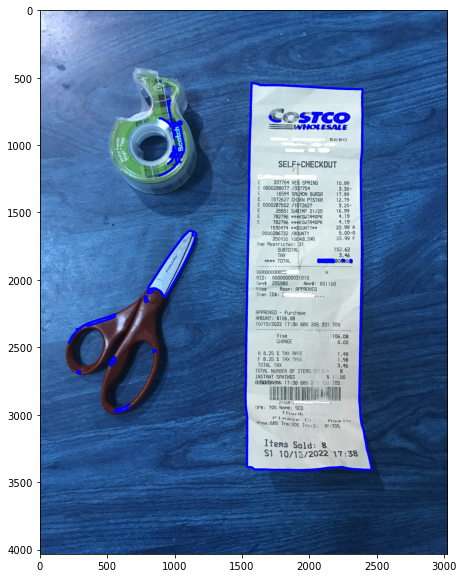

In [49]:
# read out contours
# draw contour on top of image
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
imgContoured = cv2.drawContours(img.copy(), contours, -1, (0,0,255), 15)

plt.figure(figsize = (10,10))
plt.imshow(imgContoured)
plt.show()

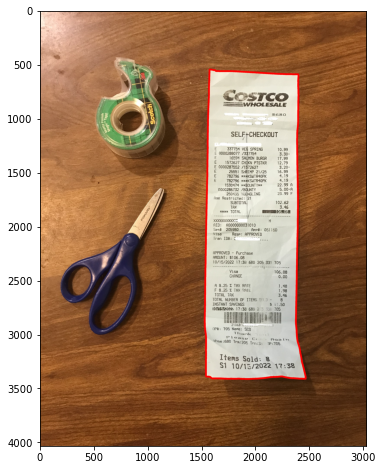

In [50]:
# Get the largest contours
receiptContour = sorted(contours, key = cv2.contourArea, reverse = True)[:1]
imgReceipt = cv2.drawContours(img.copy(), receiptContour, -1, (0,0,255), 15)

plt.figure(figsize = (8,8))
plt.imshow(cv2.cvtColor(imgReceipt, cv2.COLOR_BGR2RGB))
plt.show()

In [51]:
for c in receiptContour:
    perimeter = cv2.arcLength(c,True)
    epsilon = 0.03*perimeter
    approx = cv2.approxPolyDP(c, epsilon, True)
    if len(approx) == 4:
        fourPointsReceiptContour = approx

In [52]:
fourPointsReceiptContour

array([[[1568,  542]],

       [[1535, 3385]],

       [[2456, 3408]],

       [[2389,  588]]], dtype=int32)

In [53]:
pts = fourPointsReceiptContour.reshape(4, 2)
print(pts)
rect = np.zeros((4, 2), dtype = "float32")

s = pts.sum(axis = 1)
rect[0] = pts[np.argmin(s)]
rect[2] = pts[np.argmax(s)]

diff = np.diff(pts, axis = 1)
rect[1] = pts[np.argmin(diff)]
rect[3] = pts[np.argmax(diff)]

[[1568  542]
 [1535 3385]
 [2456 3408]
 [2389  588]]


In [54]:
rect

array([[1568.,  542.],
       [2389.,  588.],
       [2456., 3408.],
       [1535., 3385.]], dtype=float32)

In [55]:
(tl, tr, br, bl) = rect

# width of target image
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

# height of target image
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

# final size
maxWidth = max(int(widthA), int(widthB))
maxHeight = max(int(heightA), int(heightB))

# define the target matrix
dst = np.array([[0, 0],[maxWidth - 1, 0],[maxWidth - 1, maxHeight - 1],[0, maxHeight - 1]], dtype = "float32")

# transform matrix
M = cv2.getPerspectiveTransform(rect, dst)

# final transformed image
warpImg = cv2.warpPerspective(img.copy(), M, (maxWidth, maxHeight))

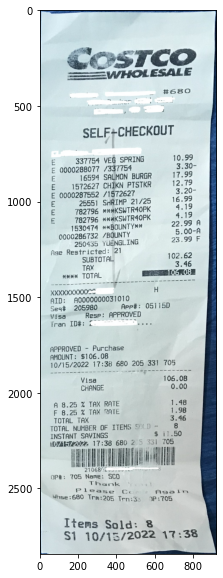

In [56]:
plt.figure(figsize=(16,10))
plt.imshow(warpImg)
plt.show()

In [57]:
#Save out cleaned image image locally
output = Image.fromarray(warpImg)
output.save('IMG_6150_OutReceipt.png')

# Text Location detection

* in this session, extracting bought items from the receipt really depends on the layout of your receipt <br>
* This just demostrates how I processed the receipt I shown here. 

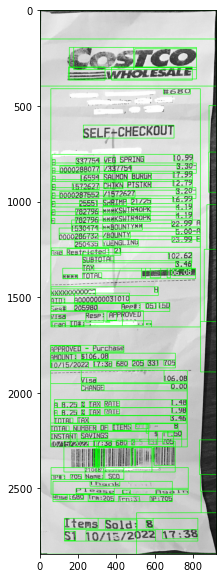

In [58]:
# read back the cleaned receipt
file_name = './IMG_6150_OutReceipt.png'
img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 

# tersseract directory installed at local computer
pytesseract.pytesseract.tesseract_cmd = 'C:\\Users\\ychen\\AppData\\Local\\Tesseract-OCR\\tesseract.exe'
d = pytesseract.image_to_data(img, output_type=Output.DICT)

n_boxes = len(d['level'])
boxes = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(16,10))
plt.imshow(boxes)
plt.show()

# Select Text

In [59]:
extracted_text = pytesseract.image_to_string(img, lang='eng')
print(extracted_text)

75 7TCO
——————— WVJHIOLESALE

#H6ESO
SELF+CHECKOUT
E 337754 VEG SPRING 10.99
E 0000288077 /337754 5r30-
E 16594 SALMON BURGR 17.99
E 1572627 CHIKN PTSTKR 12.79
E 0000287552 /1572627 3.20-
E 25551 SHRIMP 21/25 16.99
E 782796 ***KSWTIR4OPK 4.19
E 782796 %x¥KSWTR4OPK 4.19
1530474 **BOUNTY** 22-9980
0000286732 /BOUNTY 5.00-A
250435 YUENGLING 23.99 F
Age Restricted: 21
SUBTOTAL 102.62
TAX 3.46
#000 TOTAL | pan 1 06.08]
XXXXXXXXXMs H
AID: 0000000031010
Sea# 205980 Appe#: 051 15D
Visa Resp: sii Sadie
fran ID#: ea a

APPROVED - Purchase

AMOUNT: $106.08
10/15/2022 17:38 680 205 331 705

Visa 106.08

CHANGE 0.00
A 8.25 % TAX RATE 1.48
F 8.25 % TAX RATE 1.98
TOTAL TAX 3.46
TOTAL NUMBER OF ITEMS 5*" ! 8
a SAVINGS 1.50

ele. 17:38 680 2 ° 31 708

Wl AN WE

OP#: 705 tone “Sto
Please Cc Asain

Thank
“hse :680 Trm:205 Trn:35 P:705

Items Sold: 8
S1 10/15/2022 17:38



In [60]:
custom_config = r'--oem 3 --psm 6'
extracted_text2 = pytesseract.image_to_string(img, lang='eng', config=custom_config)
print(extracted_text2)

CosTCco
== WHOLESALE
somata _ #680
SELF+CHECKOUT
E 337754 VEG SPRING 10.99
E 0000288077 /337754 3.30-
E 16594 SALMON BURGR 17.99
B 1572627 CHIKN PTSTKR i202
EF 0000287552 /1572627 3.20-
E 25551 SHRIMP 21/25 16.99
Ei 782796 xHRKSWTRIOPK 4.19
E 782796 «KK SWTRIOPK 4.19
1530474 »*%BOUNT Y# 22.99 A
0000286732 /BOUNTY 5.00-A
250435 YUENGLING 23.99 F
Age Restricted: 21
SUBTOTAL 102.62
TAX 3.46
3000 TOTAL | gan} 06.08
XXXXXXXXXK- i H
AID: A0000000031010
Seq# 205980 Ape#: 051 15D
Visa Resp: APPROVED
Ht) a. .-
APPROVED - Purchase
AMOUNT: $106.08
10/15/2022 17:38 680 205 331 705
Visa ue 9106.08
CHANGE 0.00
A 8.25 % TAX RATE 1.498
F 8.25 % TAX RATE 1.98
TOTAL TAX 3.46
TOTAL NUMBER OF ITEMS 5!) 0 = 8
INSTANT SAVINGS $ 11.50
Woyakevyeleee. 17:38 680 2 ° 531 705
HAL AMON AMML
W068 Seeesew an
OP#: 705 Name: SCO
Thank
Please le SS
Whse:680 Trm:206 Tenis: PST08
Items Sold: 8
S1 10/15/2022 17:38



# Extract out saled items and price

In [61]:
# Extract out items sold with price
item_line = []
for line in extracted_text.splitlines():
    if re.search(r"[0-9]*\.[0-9]|[0-9]*\,[0-9]", line):
        print(line)        
        item_line.append(line)

E 337754 VEG SPRING 10.99
E 16594 SALMON BURGR 17.99
E 1572627 CHIKN PTSTKR 12.79
E 0000287552 /1572627 3.20-
E 25551 SHRIMP 21/25 16.99
E 782796 ***KSWTIR4OPK 4.19
E 782796 %x¥KSWTR4OPK 4.19
0000286732 /BOUNTY 5.00-A
250435 YUENGLING 23.99 F
SUBTOTAL 102.62
TAX 3.46
#000 TOTAL | pan 1 06.08]
AMOUNT: $106.08
Visa 106.08
CHANGE 0.00
A 8.25 % TAX RATE 1.48
F 8.25 % TAX RATE 1.98
TOTAL TAX 3.46
a SAVINGS 1.50


In [62]:
item_line[2:5]

['E 1572627 CHIKN PTSTKR 12.79',
 'E 0000287552 /1572627 3.20-',
 'E 25551 SHRIMP 21/25 16.99']

In [63]:
# Extract out items sold with price
item_line2 = []
for line in extracted_text2.splitlines():
    if re.search(r"[0-9]*\.[0-9]|[0-9]*\,[0-9]", line):
        print(line)        
        item_line2.append(line)

E 337754 VEG SPRING 10.99
E 0000288077 /337754 3.30-
E 16594 SALMON BURGR 17.99
EF 0000287552 /1572627 3.20-
E 25551 SHRIMP 21/25 16.99
Ei 782796 xHRKSWTRIOPK 4.19
E 782796 «KK SWTRIOPK 4.19
1530474 »*%BOUNT Y# 22.99 A
0000286732 /BOUNTY 5.00-A
250435 YUENGLING 23.99 F
SUBTOTAL 102.62
TAX 3.46
3000 TOTAL | gan} 06.08
AMOUNT: $106.08
Visa ue 9106.08
CHANGE 0.00
A 8.25 % TAX RATE 1.498
F 8.25 % TAX RATE 1.98
TOTAL TAX 3.46
INSTANT SAVINGS $ 11.50


In [72]:
item_line2[:3] +item_line[2:5]+ item_line2[5:]

['E 337754 VEG SPRING 10.99',
 'E 0000288077 /337754 3.30-',
 'E 16594 SALMON BURGR 17.99',
 'E 1572627 CHIKN PTSTKR 12.79',
 'E 0000287552 /1572627 3.20-',
 'E 25551 SHRIMP 21/25 16.99',
 'Ei 782796 xHRKSWTRIOPK 4.19',
 'E 782796 «KK SWTRIOPK 4.19',
 '1530474 »*%BOUNT Y# 22.99 A',
 '0000286732 /BOUNTY 5.00-A',
 '250435 YUENGLING 23.99 F',
 'SUBTOTAL 102.62',
 'TAX 3.46',
 '3000 TOTAL | gan} 06.08',
 'AMOUNT: $106.08',
 'Visa ue 9106.08',
 'CHANGE 0.00',
 'A 8.25 % TAX RATE 1.498',
 'F 8.25 % TAX RATE 1.98',
 'TOTAL TAX 3.46',
 'INSTANT SAVINGS $ 11.50']

In [73]:
mrg_lines = item_line2[:3] +item_line[2:5]+ item_line2[5:]

mrg_lines

['E 337754 VEG SPRING 10.99',
 'E 0000288077 /337754 3.30-',
 'E 16594 SALMON BURGR 17.99',
 'E 1572627 CHIKN PTSTKR 12.79',
 'E 0000287552 /1572627 3.20-',
 'E 25551 SHRIMP 21/25 16.99',
 'Ei 782796 xHRKSWTRIOPK 4.19',
 'E 782796 «KK SWTRIOPK 4.19',
 '1530474 »*%BOUNT Y# 22.99 A',
 '0000286732 /BOUNTY 5.00-A',
 '250435 YUENGLING 23.99 F',
 'SUBTOTAL 102.62',
 'TAX 3.46',
 '3000 TOTAL | gan} 06.08',
 'AMOUNT: $106.08',
 'Visa ue 9106.08',
 'CHANGE 0.00',
 'A 8.25 % TAX RATE 1.498',
 'F 8.25 % TAX RATE 1.98',
 'TOTAL TAX 3.46',
 'INSTANT SAVINGS $ 11.50']

In [74]:
# remove unuseful information
exclude_lst = ['TOTAL', 'Visa', 'CHANGE', 'TAX RATE', 'TOTAL TAX', 'INSTANT']

buy_items = []
for line in mrg_lines:
    found = False
    for exclude in exclude_lst:
        if exclude in line:
            found = True
        
    if found == False:
        buy_items.append(line)
print(buy_items)

['E 337754 VEG SPRING 10.99', 'E 0000288077 /337754 3.30-', 'E 16594 SALMON BURGR 17.99', 'E 1572627 CHIKN PTSTKR 12.79', 'E 0000287552 /1572627 3.20-', 'E 25551 SHRIMP 21/25 16.99', 'Ei 782796 xHRKSWTRIOPK 4.19', 'E 782796 «KK SWTRIOPK 4.19', '1530474 »*%BOUNT Y# 22.99 A', '0000286732 /BOUNTY 5.00-A', '250435 YUENGLING 23.99 F', 'TAX 3.46', 'AMOUNT: $106.08']


In [75]:
# get the price
buy_items_price = []
for line in buy_items:
    line = line.replace(",", ".")
    cost = re.findall('\d*\.?\d+\-|\d*\.?\d+|',line)
    
    print(cost)
    
    for price in cost:
        if "." in price:
            if "-" in price:
                price = '-'+price[:-1]
            buy_items_price.append(price)
print(buy_items_price)


['', '', '337754', '', '', '', '', '', '', '', '', '', '', '', '', '10.99', '']
['', '', '0000288077', '', '', '337754', '', '3.30-', '']
['', '', '16594', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '17.99', '']
['', '', '1572627', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '12.79', '']
['', '', '0000287552', '', '', '1572627', '', '3.20-', '']
['', '', '25551', '', '', '', '', '', '', '', '', '21', '', '25', '', '16.99', '']
['', '', '', '782796', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '4.19', '']
['', '', '782796', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '4.19', '']
['1530474', '', '', '', '', '', '', '', '', '', '', '', '', '', '22.99', '', '', '']
['0000286732', '', '', '', '', '', '', '', '', '', '5.00-', '', '']
['250435', '', '', '', '', '', '', '', '', '', '', '', '23.99', '', '', '']
['', '', '', '', '3.46', '']
['', '', '', '', '', '', '', '', '', '106.08', '']
['10.99', '-3.30', '17.99', '12.79', '-3.20', '16.99', '4

In [76]:
# separate out the items' name
count = 0;
buy_items_only = []
for item in buy_items:
    alpha = ""
    for c in item:
        if c.isalpha() or c.isspace():
            alpha += c
            
    alpha = re.sub(r'(?:^| )\w(?:$| )', ' ', alpha).strip()
    if alpha == '':
        #buy_items_only.append(buy_items_only[-1])
        buy_items_only.append('Discount')
    else:
        buy_items_only.append(alpha)
print(buy_items_only)

['VEG SPRING', 'Discount', 'SALMON BURGR', 'CHIKN PTSTKR', 'Discount', 'SHRIMP', 'Ei  xHRKSWTRIOPK', 'KK SWTRIOPK', 'BOUNT', 'BOUNTY', 'YUENGLING', 'TAX', 'AMOUNT']


# Display as a table

In [77]:
# merge table together
t = PrettyTable(['Bought Items', 'Price'])
for counter in range (0,len(buy_items_only)):
    t.add_row([buy_items_only[counter], buy_items_price[counter]])
print(t)

+------------------+--------+
|   Bought Items   | Price  |
+------------------+--------+
|    VEG SPRING    | 10.99  |
|     Discount     | -3.30  |
|   SALMON BURGR   | 17.99  |
|   CHIKN PTSTKR   | 12.79  |
|     Discount     | -3.20  |
|      SHRIMP      | 16.99  |
| Ei  xHRKSWTRIOPK |  4.19  |
|   KK SWTRIOPK    |  4.19  |
|      BOUNT       | 22.99  |
|      BOUNTY      | -5.00  |
|    YUENGLING     | 23.99  |
|       TAX        |  3.46  |
|      AMOUNT      | 106.08 |
+------------------+--------+
